In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = sio.loadmat("ex5data1.mat")
data
X, y, Xval, yval, Xtest, ytest = map(np.ravel,[data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']])
X.shape, y.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((12,), (12,), (21,), (21,), (21,), (21,))

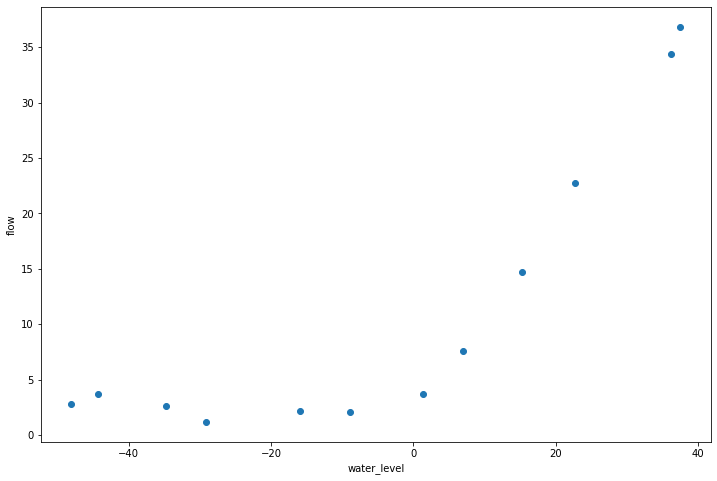

In [3]:
fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(X,y)
ax.set_xlabel("water_level")
ax.set_ylabel("flow")
plt.show()

In [4]:
X,Xval,Xtest = [np.insert(x.reshape(x.shape[0],1),0,values=np.ones(x.shape[0]),axis = 1) for x in (X,Xval,Xtest)]

In [5]:
X.shape,Xval.shape,Xtest.shape

((12, 2), (21, 2), (21, 2))

In [6]:
def cost(theta,X,y):
    m=X.shape[0]
    inner = X @ theta -y
    inner_square = inner.T @ inner
    
    return inner_square/(2*m)
    

In [7]:
def costReg(theta,X,y,reg=1):
    m=X.shape[0]
    regularized_term=(reg/(2*m))*np.power(theta.ravel()[1:],2).sum()
    
    return cost(theta,X,y)+regularized_term


In [8]:
theta=np.ones(X.shape[1])
costReg(theta,X,y)

303.9931922202643

In [9]:
X.shape,theta.shape,y.shape

((12, 2), (2,), (12,))

In [10]:
def gradient(theta,X,y):
    m=X.shape[0]
    inner = X.T @ (X @ theta - y)
    
    return inner / m

In [11]:
def gradientReg(theta,X,y,reg):
    m = X.shape[0]
    
    term = theta.copy()
    term[0] = 0
    
    term = (reg / m)*term
    
    return gradient(theta,X,y) + term

In [12]:
gradientReg(theta,X,y,1)

array([-15.30301567, 598.25074417])

In [13]:
theta=np.ones(X.shape[1])

In [14]:
final_theta = opt.minimize(fun=costReg,x0=theta,args=(X,y,0),method='TNC',jac=gradientReg,options={'disp':True}).x
final_theta

array([13.08790398,  0.36777923])

In [15]:
X.shape,y.shape

((12, 2), (12,))

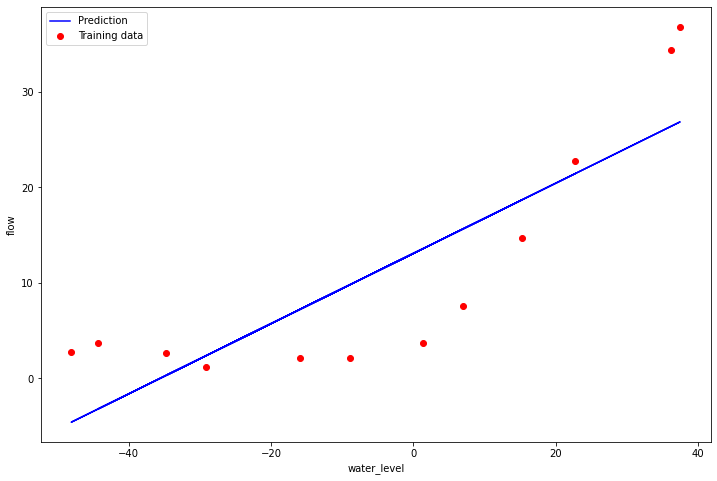

In [16]:
b=final_theta[0]
m=final_theta[1]

fig,ax = plt.subplots(figsize=(12,8))
plt.scatter(X[:,1],y,c='r',label="Training data")
plt.plot(X[:,1],X[:,0]*b+X[:,1]*m,c='b',label="Prediction")
ax.set_xlabel('water_level')
ax.set_ylabel('flow')
plt.legend()
plt.show()

In [30]:
def linear_regression(X,y,l=1):
    
    theta = np.ones(X.shape[1])
    
    res = opt.minimize(fun=costReg,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=gradientReg,
                       options={'disp':True})
    return res
    

In [31]:
training_cost=[]
cv_cost=[]

In [32]:
m=X.shape[0]
for i in range(1,m+1):
    res = linear_regression(X[:i, :], y[:i], 0)
    tc = costReg(res.x,X[:i,:],y[:i],0)
    cv = costReg(res.x,Xval,yval,0)

    training_cost.append(tc)
    cv_cost.append(cv)


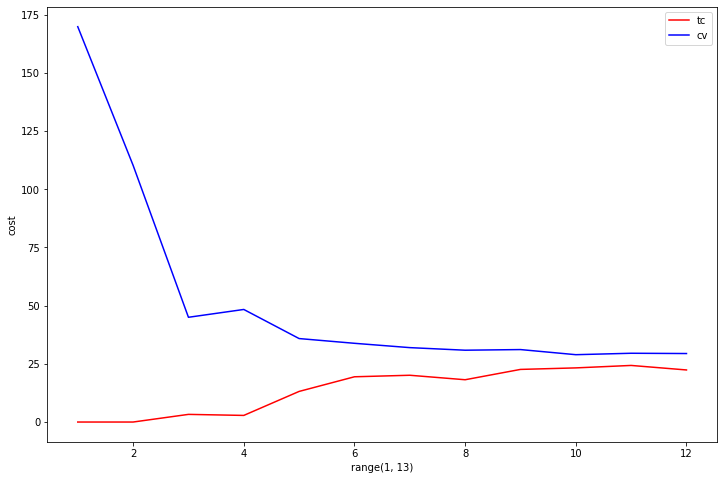

In [33]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(range(1,m+1),training_cost,c='r',label="tc")
plt.plot(range(1,m+1),cv_cost,c='b',label="cv")
plt.xlabel(range(1,m+1))
plt.ylabel("cost")
plt.legend()
plt.show()

In [36]:
X.shape

(12, 2)

In [44]:
power = 6

def feature_mapping(x,power,as_ndarry=False):
    data={'f{}'.format(i):np.power(x,i) for i in range(1,power+1)}
    df=pd.DataFrame(data)
    return df.values if as_ndarry else df


In [45]:
data = sio.loadmat('ex5data1.mat')
X,y,Xval,yval,Xtest,ytest=map(np.ravel,[data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']])

In [47]:
X_new = feature_mapping(X,power=6)

In [51]:
def normalize_feature(df):
    return df.apply(lambda column:(column - column.mean())/column.std())

In [52]:
def prepare_poly_data(*args,power):
    def prepare(X):
        df = feature_mapping(X,power=power)
        ndarr=normalize_feature(df).values
        return np.insert(ndarr,0,np.ones(ndarr.shape[0]),axis=1)
    return [prepare(X) for X in args]


In [65]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3,:]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

In [70]:
def plot_learning_curve(X, Xinit, y, Xval, yval, l=0):
    training_cost=[]
    cv_cost=[]
    m=X.shape[0]

    for i in range(1,m+1):

        res = linear_regression(X[:i,:],y[:i],l=1)

        training_cost.append(cost(res.x,X[:i,:],y[:i]))
        cv_cost.append(cost(res.x,Xval,yval))

    fig,ax = plt.subplots(2,1,figsize=(12,8))
    ax[0].plot(np.arange(1,m+1),training_cost,c='r',label="tc")
    ax[0].plot(np.arange(1,m+1),cv_cost,c='b',label="cv")
    ax[0].set_xlabel(range(1,m+1))
    ax[0].set_ylabel("cost")
    ax[0].legend()

    fitx=np.linspace(-50,50,1000)
    fitxtemp = prepare_poly_data(fitx,power=8)
    fity = np.dot(prepare_poly_data(fitx,power=8)[0],linear_regression(X,y,l).x.T)

    ax[1].plot(fitx, fity, c='r', label='fitcurve')
    ax[1].scatter(Xinit, y, c='b', label='initial_Xy')

    ax[1].set_xlabel('water_level')
    ax[1].set_ylabel('flow')

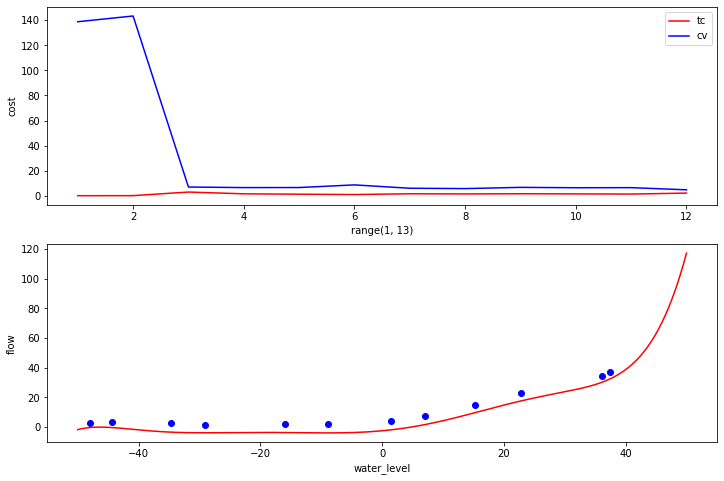

In [71]:

plot_learning_curve(X_poly, X, y, Xval_poly, yval, l=0)
plt.show()